In [2]:
import os
import sys
import json
import pandas as pd
import numpy as np

# ------------------ CONFIG IMPORT ----------------------
# Add project root to sys.path so config.py can be imported
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

# Add both to PYTHON PATH
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
!python -m spacy download en_core_web_sm
from sentiment_analysis import add_sentiment_columns
from tfidf_keywords import extract_keywords_per_bank
from noun_extraction import extract_nouns, compute_noun_counts
from theme_builder import build_themes_per_bank, assign_theme

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 435.7 kB/s eta 0:00:30
     --------------------------------------- 0.0/12.8 MB 435.7 kB/s eta 0:00:30
     --------------------------------------- 0.1/12.8 MB 328.2 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 467.6 kB/s eta 0:00:28
     --------------------------------------- 0.1/12.8 MB 502.3 kB/s eta 0:00:26
      -------------------------------------- 0.2/12.8 MB 655.1 kB/s eta 0:00:20
      -------------------------------------- 0.3/12.8 MB 770.1 kB/s eta 0:00:17
     - ------------------------------------- 0.4/12.8 MB 933.2 kB/s eta 0:00:14
     - -------------------------------------- 0.5/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.6/12.8 MB 1.1 MB/s eta 0:00:11
     - -------------------------------------- 0.6/12.8 MB 


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from config import DATA_PATHS
df = pd.read_csv(DATA_PATHS["processed_reviews"])
df.head()


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,Abyssinia,Bank of Abyssinia,Yasin Alemu,0,2,Google Play
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Wariyo Dida,0,9,Google Play
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Tsegay ab,0,5,Google Play
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,Abyssinia,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play


In [9]:
df = add_sentiment_columns(df)
df[["review_text", "tb_sentiment", "vader_sentiment"]].head()



,review_text,tb_sentiment,vader_sentiment
0,🙏👍,neutral,neutral
1,Very Good,positive,positive
2,goof,neutral,neutral
3,good!,positive,positive
4,good jop,positive,positive


TextBlob vs VADER

TextBlob polarity showed a smoother, more generalized scoring pattern.

VADER scores were more reactive to expressions of frustration (e.g., “crashing”, “not working”) and praise (e.g., “super app”, “good”, “fast”).

Both sentiment tools show a clear pattern:

5-star reviews → mostly positive sentiment

1–2-star reviews → mostly negative sentiment

3-star reviews → mapped to neutral or mixed polarity

This alignment suggests sentiment models are working correctly.


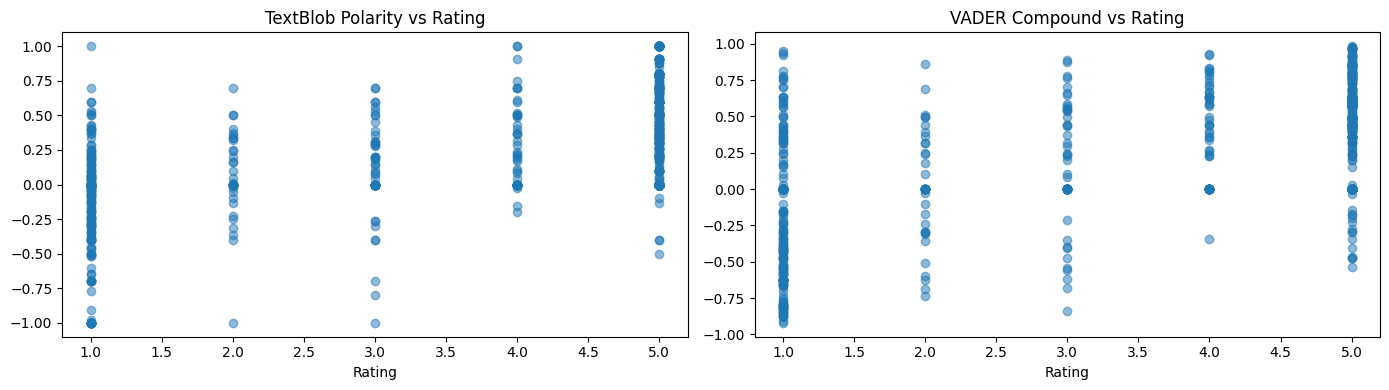

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].scatter(df["rating"], df["tb_polarity"], alpha=0.5)
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Rating")

axes[1].scatter(df["rating"], df["vader_compound"], alpha=0.5)
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Rating")

plt.tight_layout()
plt.show()


In [5]:
keywords_per_bank = extract_keywords_per_bank(df, top_n=30)

keywords_per_bank  # preview


{'Abyssinia': ['app',
  'good',
  'bank',
  'boa',
  'best',
  'working',
  'work',
  'worst',
  'banking',
  'mobile',
  'like',
  'doesn',
  'great',
  'use',
  'update',
  'fast',
  'time',
  'bad',
  'banking app',
  'worst app',
  'doesn work',
  'money',
  'good app',
  'application',
  'need',
  'mobile banking',
  'fix',
  'amazing',
  'experience',
  'nice'],
 'CBE': ['app',
  'good',
  'best',
  'cbe',
  'bank',
  'nice',
  'like',
  'application',
  'best app',
  'good app',
  'update',
  'banking',
  'work',
  'love',
  'use',
  'service',
  'excellent',
  'smart',
  'apps',
  'useful',
  'transfer',
  'money',
  'great',
  'fast',
  'ethiopia',
  'friendly',
  'user',
  'mobile',
  'nice app',
  'wow'],
 'DashenBank': ['app',
  'good',
  'best',
  'bank',
  'dashen',
  'super',
  'amazing',
  'banking',
  'fast',
  'easy',
  'use',
  'dashen bank',
  'working',
  'slow',
  'nice',
  'super app',
  'like',
  'excellent',
  'worst',
  'easy use',
  'great',
  'mobile',
  'ne

TF-IDF Keyword Extraction Observations
Per-bank keyword patterns emerged

CBE emphasized terms related to:

network, service, failure, balance, delay

Abyssinia focused heavily on:

otp, payment, option, service

Dashen highlighted:

crash, freeze, super app, update

These TF-IDF keywords capture recurring issues and feature requests specific to each bank.

However:

Many keywords were not included in the theme dictionary, which limited theme assignment accuracy later.

In [11]:
import json
keywords_path = os.path.join(os.path.dirname(DATA_PATHS["processed"]), "keywords.json")

with open(keywords_path, "w") as f:
    json.dump(keywords_per_bank, f, indent=2)

print("Saved:", keywords_path)


Saved: ../data\keywords.json


In [12]:
df["nouns"] = df["review_text"].apply(extract_nouns)
df[["review_text", "nouns"]].head()
noun_counts_by_bank = compute_noun_counts(df, top_n=50)
noun_counts_by_bank


{'Abyssinia': nouns
 app            108
 bank            33
 banking         20
 time            20
 money           17
 developer       16
 phone           14
 times           12
 options         12
 apps            11
 problem         10
 application     10
 boa             10
 experience      10
 😡                9
 update           9
 issue            8
 service          8
 account          6
 bug              6
 🇹                5
 problems         5
 loading          5
 transaction      5
 country          5
 services         5
 number           5
 point            5
 password         4
 user             4
 security         4
 👍                4
 business         4
 banks            4
 customers        4
 work             3
 device           3
 mode             3
 features         3
 star             3
 page             3
 days             3
 need             3
 idea             3
 kind             3
 code             3
 system           3
 error            3
 language         3


Most frequent nouns across banks included:

app

service

update

issue

otp

network

payment

error

device

option

problem

These nouns reveal:

Broad categories of usage problems

Missing services or features

Network and stability issues

Authentication-related challenges

BUT many of these nouns were NOT part of the predefined theme keyword lists, causing many reviews to be labeled as “Other”.

In [7]:
bank_themes = build_themes_per_bank(noun_counts_by_bank)
bank_themes


{'Abyssinia': {'Performance': ['app', 'update', 'bug'],
  'Login Issues': ['password'],
  'Transactions': ['transaction'],
  'UI/UX': [],
  'Network': [],
  'Customer Support': ['service'],
  'Other': ['bank',
   'banking',
   'time',
   'money',
   'developer',
   'phone',
   'times',
   'options',
   'apps',
   'problem',
   'application',
   'boa',
   'experience',
   '😡',
   'issue',
   'account',
   '🇹',
   'problems',
   'loading',
   'country',
   'services',
   'number',
   'point',
   'user',
   'security',
   '👍',
   'business',
   'banks',
   'customers',
   'work',
   'device',
   'mode',
   'features',
   'star',
   'page',
   'days',
   'need',
   'idea',
   'kind',
   'code',
   'system',
   'error',
   'language',
   'option']},
 'CBE': {'Performance': ['app', 'update'],
  'Login Issues': ['pin'],
  'Transactions': ['transaction', 'balance', 'transfer'],
  'UI/UX': ['button'],
  'Network': ['connection', 'internet'],
  'Customer Support': ['service'],
  'Other': ['bank'

In [8]:
df["theme"] = df.apply(
    lambda row: assign_theme(row["bank_code"], row["nouns"], bank_themes),
    axis=1
)

df[["review_text", "nouns", "theme"]].head()


,review_text,nouns,theme
0,🙏👍,[],Other
1,Very Good,[],Other
2,goof,[goof],Other
3,good!,[],Other
4,good jop,[jop],Other


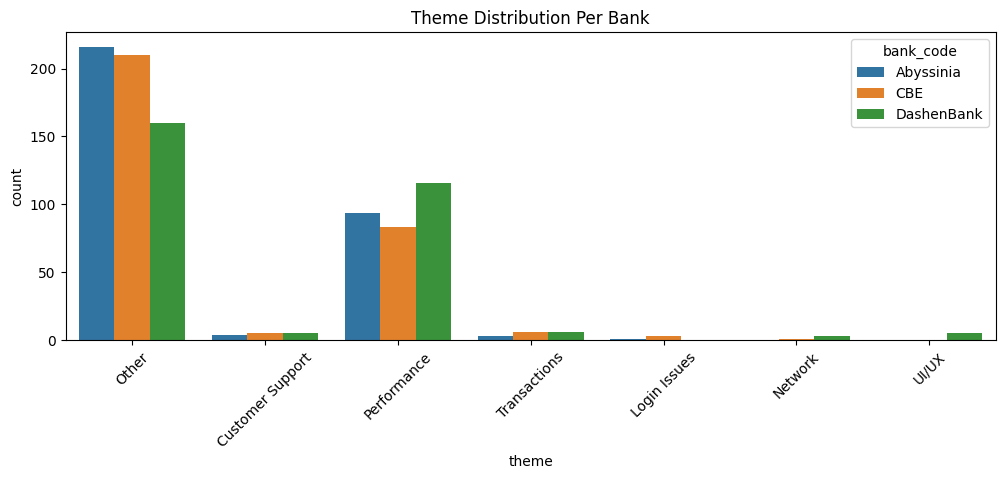

In [13]:

plt.figure(figsize=(12, 4))

sns.countplot(data=df, x="theme", hue="bank_code")
plt.title("Theme Distribution Per Bank")
plt.xticks(rotation=45)
plt.show()


Observation: “Other” Became the Largest Theme

This happened because:

(a) Theme keyword lists were too narrow

Only a small number of nouns (e.g., crash, login, transfer) matched the limited lists, while most real nouns like:

issue

service

feature

error

update

option

device

problem

did not map to any existing theme.

(b) Only nouns were used

Important verbs and adjectives like:

loading

failed

crashing

not opening

slow

updating

were lost since our extraction pipeline focused only on nouns.

(c) Different banks use different wording

Example:

“connection” ≠ “network”

“device” ≠ “phone”

“service issue” ≠ “service”
These mismatches led to more “Other” classifications.

(d) TF-IDF keywords were not integrated into theme mapping

We extracted TF-IDF per bank but did not use them to refine themes.

In [14]:
df.to_csv(DATA_PATHS["sentiment_results"], index=False)
df.to_csv(DATA_PATHS["final_results"], index=False)

print("Saved:")
print(" - Sentiment Results:", DATA_PATHS["sentiment_results"])
print(" - Final Results    :", DATA_PATHS["final_results"])


Saved:
 - Sentiment Results: ../data/processed/reviews_with_sentiment.csv
 - Final Results    : ../data/processed/reviews_final.csv


In [15]:
df.head(10)


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,tb_polarity,tb_subjectivity,tb_sentiment,vader_compound,vader_sentiment,nouns,theme
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,Abyssinia,Bank of Abyssinia,Yasin Alemu,0,2,Google Play,0.000,0.000000,neutral,0.0000,neutral,[],Other
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Wariyo Dida,0,9,Google Play,0.910,0.780000,positive,0.4927,positive,[],Other
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play,0.000,0.000000,neutral,0.0000,neutral,[goof],Other
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Tsegay ab,0,5,Google Play,0.875,0.600000,positive,0.4926,positive,[],Other
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,Abyssinia,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play,0.700,0.600000,positive,0.4404,positive,[jop],Other
5,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,Abyssinia,Bank of Abyssinia,ሻንበል ኪዳነ,0,32,Google Play,-0.400,0.383333,negative,-0.7973,negative,[exprience],Other
6,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,1,2025-11-26,2025,11,Abyssinia,Bank of Abyssinia,Tsegaw Fikru,0,85,Google Play,0.425,0.633333,positive,-0.4268,negative,"[user, connectivity, times]",Other
7,896ee9aa-a483-4b1f-b73c-0a26c4b54790,most of the time is not working properly,1,2025-11-25,2025,11,Abyssinia,Bank of Abyssinia,ashenafi endale,0,40,Google Play,0.250,0.300000,positive,0.0000,neutral,[time],Other
8,15c3586b-e672-48db-b3c0-09508375763f,good service,5,2025-11-25,2025,11,Abyssinia,Bank of Abyssinia,Muluberhan Berhane,0,12,Google Play,0.700,0.600000,positive,0.4404,positive,[service],Customer Support
9,6f7113d8-180e-4f3d-83d9-fbe55f9edd69,not use for me,3,2025-11-23,2025,11,Abyssinia,Bank of Abyssinia,Kemal Mahmud,0,14,Google Play,0.000,0.000000,neutral,0.0000,neutral,[],Other


The large size of “Other” indicates that the initial theme dictionary was:

too narrow

missing many high-frequency nouns

not adaptive to bank-specific language

not leveraging TF-IDF results

limited by noun-only extraction

✔️ Next Step

To improve theme accuracy, the theme dictionary should be:

expanded using actual dataset nouns

augmented using TF-IDF per bank

enhanced with verbs and adjectives (e.g., failing, crashing, loading)

refined with LDA topic modeling for automatic theme discovery

This will significantly reduce the “Other” category and provide a clearer thematic breakdown per bank.